## Introduction to the GLM

Now that the data is clean we can perform analysis. Resting state analysis is completed in notebook 6. This is a review of the general linear model using data that was collected during a breathholding task. 

### Step 1: Ensure you have data from the breath-hold task downloaded to your local machine. 
    
    #TODO: link to download, currently aws but Erin may move to datalad
    
### Step 2: We need to figure out the stimulus for the breath holding task. 

The description of this task is contained in `data/ds000030/task-bht_bold.json`. Lets load in the nessecary folders and see what information we can find. We can do this using the terminal command cat.

In [7]:
cat ../data/ds000030/task-bht_bold.json

{
    "TaskName": "bht",
    "TaskFullName": "Breath-Holding Task",
    "Instructions": "Demo Instructions: During this task we will periodically ask you to hold your breath for 13.5 seconds at a time. After each breath hold, you will be given a rest period to breathe normally. For the practice, this will go on for 2 cycles, so you will need to hold your breath 2 separate times. During the scan, you will need to hold your breath 5 times. The task starts out with 13.5 sec of normal breathing. During these periods of regular breathing, you will see a green bar on the screen. When it’s almost time to hold your breath, you will see a yellow bar. A blue line will travel upwards. As it moves, you should take a breath and prepare to hold it. When the blue line reaches the top, the bar will turn red and you should start holding your breath. During the entire time that the bar is red, you should not breathe (in or out). After 13.5 seconds, the bar will turn green, and you can start breathing no

In [8]:
cat ../data/ds000030/sub-10171/func/sub-10171_task-bht_bold.json

{
        "ImageType": "ORIGINAL/PRIMARY/M/ND/MOSAIC",
        "ManufacturerModelName": "TrioTim",
        "ScanningSequence": "EP",
        "SequenceVariant": "SK",
        "ScanOptions": "FS",
        "MRAcquisitionType": "2D",
        "SequenceName": "*epfid2d1_64",
        "RepetitionTime": 2,
        "EchoTime": 0.03,
        "NumberOfAverages": 1,
        "ImagingFrequency": 123249622,
        "MagneticFieldStrength": 3,
        "NumberOfPhaseEncodingSteps": 63,
        "EchoTrainLength": 1,
        "PercentSampling": 100,
        "PercentPhaseFieldOfView": 100,
        "PixelBandwidth": 1420,
        "EPIFactor": 128,
        "AccelerationFactorPE": 2,
        "AccelNumReferenceLines": 24,
        "TotalScanTimeSec": 212,
        "ReceiveCoilName": "HeadMatrix",
        "DeviceSerialNumber": "35343",
        "SoftwareVersions": "syngo MR B15",
        "ProtocolName": "BOLD - BHT",
        "TransmitCoilName": "Body",
        "AcquisitionMatrix": "64/0/0/64",
        "InPlanePhase

(267, 28)


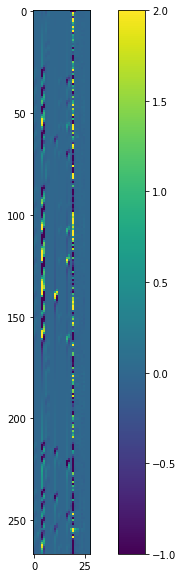

In [24]:
%matplotlib inline
import numpy as np
import nibabel as nb
from nilearn import plotting
import nilearn
import matplotlib.pyplot as plt

design_matrix = np.loadtxt('../sub-10171_task-bart_design.mat', skiprows=5)
plt.figure(figsize=(10,10))
plt.imshow(design_matrix, vmin=-1, vmax=2)
plt.colorbar()
print(design_matrix.shape)

### Step 3: Now that we know what stimulus was used we need to convolve it with a hemodynamic response function. 

This can be done using using the nitime.fmri.hrf function. 

    #TODO: Full guide

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


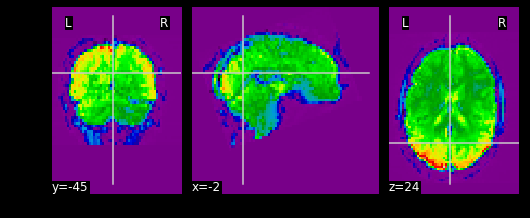

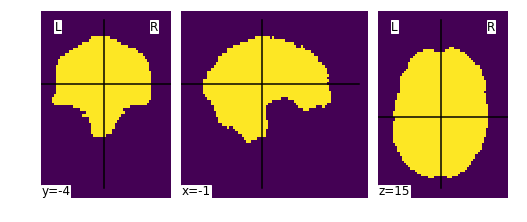

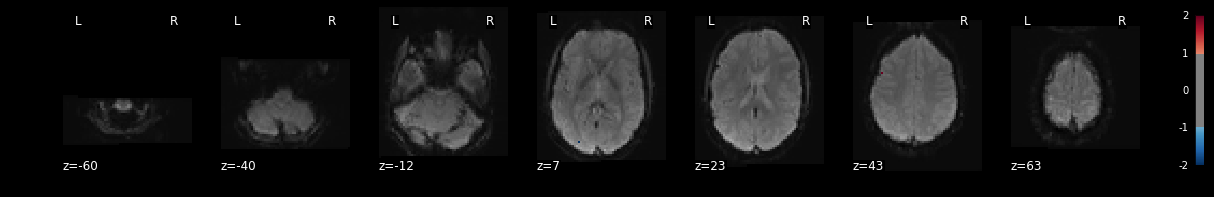

In [50]:
from nilearn.mass_univariate import permuted_ols
from nilearn.plotting import plot_stat_map
from nilearn.input_data import NiftiMasker

mask_filename='../data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-bart_bold_space-T1w_brainmask.nii.gz'
epi_filename='../data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-bart_bold_space-T1w_preproc.nii.gz'

plotting.plot_epi(nilearn.image.mean_img(epi_filename))
plotting.plot_img(mask_filename)

nifti_masker = NiftiMasker(
    smoothing_fwhm=0,
    mask_img=mask_filename,
    memory='nilearn_cache', memory_level=1)

epi_data=nifti_masker.fit_transform(epi_filename)

tested_vars = design_matrix[:,0]
confounding_vars=design_matrix[:,1:]

neg_log_pvals, t_score_orig, _ = permuted_ols(tested_vars, epi_data, confounding_vars=confounding_vars, model_intercept=True, n_perm=100, two_sided_test=True, random_state=None, n_jobs=1, verbose=1)

signed_neg_log_pvals = neg_log_pvals * np.sign(t_score_orig)

func_results = nifti_masker.inverse_transform(signed_neg_log_pvals)

mean_fmri_img = nilearn.image.mean_img('../data/ds000030/derivatives/fmriprep/sub-10171/func/sub-10171_task-bart_bold_space-T1w_preproc.nii.gz')

threshold = -np.log10(0.1)  # 10% corrected

vmax = signed_neg_log_pvals.max()

display = plot_stat_map(func_results, mean_fmri_img,
                        threshold=threshold, cmap=plt.cm.RdBu_r,
                        display_mode='z',
                        vmax=vmax)



### Step 4: Now we can fit our model of what task was acquired to our input data

This can be done using the permuted ols function from nilearn. We can also include motion confounds as before simulataneously in order to remove them during fitting opposed to cleaning the data. This is the standard for task based data.

### Step 5: Visualizing fit results

Now to visualize the results of our fit. Lets look at a plot of the most active voxel and a show an image of estimates beta weights.

We can also look at the residuals across space and time. These can show issues such as motion or physiology contamination.

### Step 6: Improving our fit with pre-whitening

The OLS fit we ran before did not take into account the covariance of our data. 

### Step 7: Wrapping up and Final Thoughts